# Incidenze

Incidenze regionali su 100'000 abitanti.

> Max Pierini

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import Markdown
import seaborn as sns

import scipy.stats as sps

sns.set()

In [2]:
istat_to_dpc = {
    "Abruzzo":     'Abruzzo',
    "Basilicata":     'Basilicata',
    "Calabria":     'Calabria',
    "Campania":     'Campania',
    "Emilia-Romagna":     'Emilia-Romagna',
    "Friuli-Venezia Giulia":     'Friuli Venezia Giulia',
    "Lazio":     'Lazio',
    "Liguria":     'Liguria',
    "Lombardia":     'Lombardia',
    "Marche":     'Marche',
    "Molise":     'Molise',
    "Provincia Autonoma Bolzano / Bozen":     'P.A. Bolzano',
    "Provincia Autonoma Trento":     'P.A. Trento',
    "Piemonte":     'Piemonte',
    "Puglia":     'Puglia',
    "Sardegna":     'Sardegna',
    "Sicilia":     'Sicilia',
    "Toscana":     'Toscana',
    "Umbria":     'Umbria',
    "Valle d'Aosta / Vallée d'Aoste":     "Valle d'Aosta",
    "Veneto":     'Veneto',
}

In [3]:
pop = pd.read_csv('ISTAT_popolazione.csv')

In [4]:
pop_reg = pop[
    (pop.Sesso=='totale') & (pop.Età=='totale') & (pop.Territorio!='Trentino Alto Adige / Südtirol')
].reset_index()[['Territorio', 'Value']]

In [5]:
pop_reg["Territorio"] = pop_reg.Territorio.map(istat_to_dpc)

In [6]:
def covid_regioni():
    df = pd.read_csv(
        "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv",
        parse_dates=['data'],
        index_col=['data'],
        squeeze=True).sort_index()
    df.index = df.index.normalize()
    return df

In [7]:
it = covid_regioni()

In [8]:
fp = it.pivot_table(index='data', columns='denominazione_regione', values='nuovi_positivi') 

fp_w = fp.resample('W').sum()

for regione in fp_w.columns:
    fp_w.loc[:,regione] = fp_w.loc[:,regione] / (pop_reg[pop_reg.Territorio==regione].Value.values) * 100000

fp_w.index = fp_w.index.strftime('%d %b %Y')

In [9]:
fp_latest = pd.DataFrame(fp.iloc[-7:].sum()).T
for regione in fp_latest.columns:
    fp_latest.loc[:,regione] = fp_latest.loc[:,regione] / (pop_reg[pop_reg.Territorio==regione].Value.values) * 100000

fp_latest.index = [fp.index.max().strftime('%d %b %Y')]

fp_latest.index.name = 'data'

fp_w = fp_w.iloc[:-1].append(fp_latest)

In [10]:
dfs = {}

for regione in it.denominazione_regione.unique():
    _df = it[it.denominazione_regione==regione].copy(deep=True)
    _df['nuovi_deceduti'] = _df.deceduti.diff()
    _df['nuovi_guariti'] = _df.dimessi_guariti.diff()
    dfs.update({regione: _df})

In [11]:
dfW = None
dfL = None
for regione in dfs:
    _dfW = dfs[regione].resample('W').sum()
    _pop_reg = pop_reg[pop_reg.Territorio==regione].Value.values[0]
    _dfW['regione'] = regione
    _dfW['incidenza_positivi'] = _dfW.nuovi_positivi / _pop_reg * 100000
    _dfW['incidenza_guariti'] = _dfW.nuovi_guariti / _pop_reg * 100000
    _dfW['incidenza_deceduti'] = _dfW.nuovi_deceduti / _pop_reg * 100000
    
    _dfL = pd.DataFrame(dfs[regione][['nuovi_positivi', 'nuovi_guariti', 'nuovi_deceduti']][-7:].sum()).T
    _dfL['regione'] = regione
    _dfL['incidenza_positivi'] = _dfL.nuovi_positivi / _pop_reg * 100000
    _dfL['incidenza_guariti'] = _dfL.nuovi_guariti / _pop_reg * 100000
    _dfL['incidenza_deceduti'] = _dfL.nuovi_deceduti / _pop_reg * 100000

    if dfW is None:
        dfW = _dfW
    else:
        dfW = dfW.append(_dfW)
    if dfL is None:
        dfL = _dfL
    else:
        dfL = dfL.append(_dfL)

# Nuovi positivi

In [12]:
i_cols = ['regione', 'incidenza_positivi', 'incidenza_deceduti']
dfX = dfW[dfW.index==dfW.index[-2]][i_cols].merge(
    dfL[i_cols],
    on='regione',
    suffixes=('_ultima_settimana', '_ultimi_7_giorni')
)

In [13]:
dfIp = dfX[[
    'regione',
    'incidenza_positivi_ultima_settimana', 'incidenza_positivi_ultimi_7_giorni'
]].set_index('regione')
dfIp.columns = ['ultima settimana', 'ultimi 7 giorni']
dfIp['differenza'] = dfIp['ultimi 7 giorni'] - dfIp['ultima settimana']
dfIp.style.set_caption("INCIDENZA POSITIVI (ordine alfabetico)").format(
    {
        'ultima settimana': '{:.2f}',
        'ultimi 7 giorni': '{:.2f}',
        'differenza': '{:+.2f}'
    }
)

,ultima settimana,ultimi 7 giorni,differenza
regione,,,
Abruzzo,14.93,12.94,-1.99
Basilicata,35.01,31.06,-3.95
Calabria,29.82,24.73,-5.09
Campania,24.66,19.44,-5.22
Emilia-Romagna,19.54,17.24,-2.31
Friuli Venezia Giulia,15.85,12.47,-3.38
Lazio,19.47,17.49,-1.98
Liguria,7.58,6.67,-0.91
Lombardia,18.70,16.57,-2.13


In [14]:
dfIp.sort_values(by='ultima settimana', ascending=False).style.set_caption(
    "INCIDENZA POSITIVI (ordine ultima settimana)"
).format(
    {
        'ultima settimana': '{:.2f}',
        'ultimi 7 giorni': '{:.2f}',
        'differenza': '{:+.2f}'
    }
)

,ultima settimana,ultimi 7 giorni,differenza
regione,,,
Sicilia,36.55,30.88,-5.68
Basilicata,35.01,31.06,-3.95
Calabria,29.82,24.73,-5.09
Toscana,25.95,22.40,-3.55
P.A. Bolzano,25.00,18.23,-6.77
Campania,24.66,19.44,-5.22
Valle d'Aosta,23.90,16.73,-7.17
P.A. Trento,21.93,13.63,-8.29
Puglia,21.23,20.06,-1.17


In [15]:
dfIp.sort_values(by='differenza', ascending=False).style.set_caption(
    "INCIDENZA POSITIVI (ordine differenza)"
).format(
    {
        'ultima settimana': '{:.2f}',
        'ultimi 7 giorni': '{:.2f}',
        'differenza': '{:+.2f}'
    }
)

,ultima settimana,ultimi 7 giorni,differenza
regione,,,
Sardegna,8.03,9.08,+1.04
Molise,8.27,9.26,+0.99
Liguria,7.58,6.67,-0.91
Puglia,21.23,20.06,-1.17
Lazio,19.47,17.49,-1.98
Abruzzo,14.93,12.94,-1.99
Lombardia,18.70,16.57,-2.13
Emilia-Romagna,19.54,17.24,-2.31
Veneto,12.49,10.11,-2.38


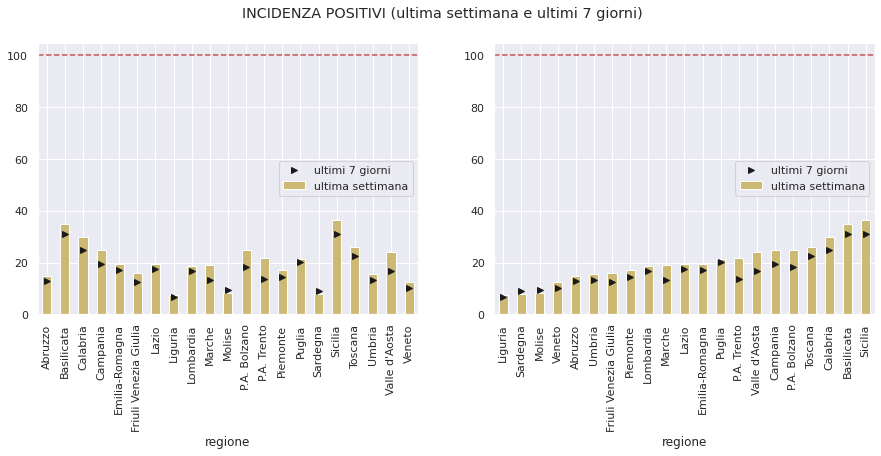

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
dfIp.plot(y='ultimi 7 giorni', ax=ax[0], color='k', marker='>', ls='none')
dfIp.plot(y='ultima settimana', ax=ax[0], color='y', kind='bar')

dfIp.sort_values(by='ultima settimana').plot(y='ultimi 7 giorni', ax=ax[1], color='k', marker='>', ls='none')
dfIp.sort_values(by='ultima settimana').plot(y='ultima settimana', ax=ax[1], kind='bar', color='y')

for axs in ax.flat:
    axs.axhline(100, color='r', ls='--')

fig.suptitle('INCIDENZA POSITIVI (ultima settimana e ultimi 7 giorni)')
plt.show()

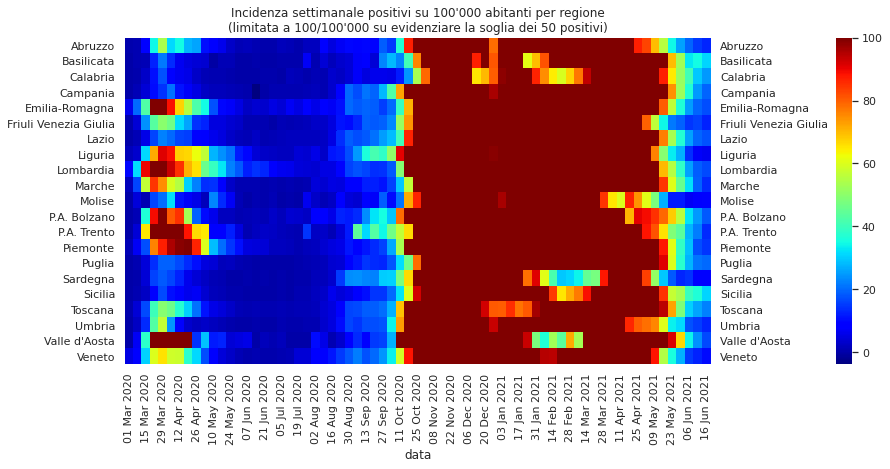

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(
    fp_w.T,
    vmax=100,
    cmap='jet',
    #linewidths=.01, linecolor='k',
    cbar_kws=dict(pad=.15),
    ax=ax
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True, rotation=0)
#x_latest = ax.get_xticks()[-2:].mean()
#ax.axvline(x_latest, color='k', lw=3)
ax.set(
    title="Incidenza settimanale positivi su 100'000 abitanti per regione\n"
    "(limitata a 100/100'000 su evidenziare la soglia dei 50 positivi)",
    ylabel=None
)
plt.show()

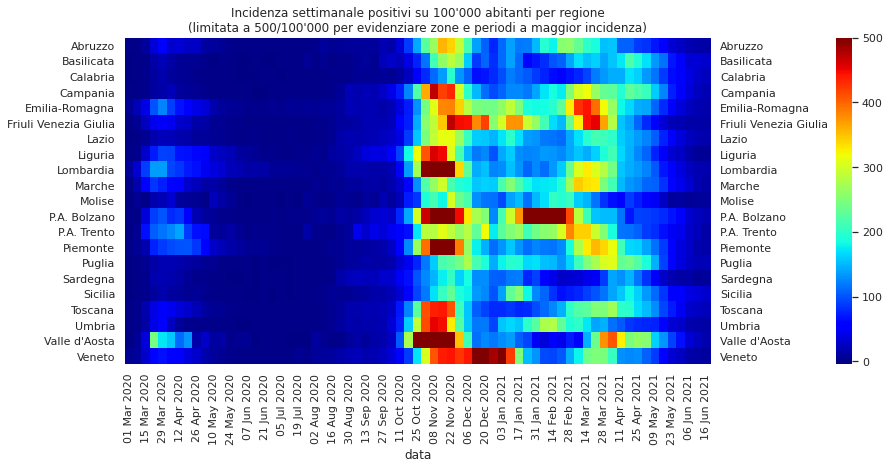

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(
    fp_w.T,
    vmax=500,
    #cmap='gray_r', 
    cmap='jet', 
    #linewidths=.01, linecolor='k',
    cbar_kws=dict(pad=.15),
    ax=ax
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True, rotation=0)
#x_latest = ax.get_xticks()[-2:].mean()
#ax.axvline(x_latest, color='k', lw=3)
ax.set(
    title="Incidenza settimanale positivi su 100'000 abitanti per regione\n"
    "(limitata a 500/100'000 per evidenziare zone e periodi a maggior incidenza)",
    ylabel=None
)
plt.show()

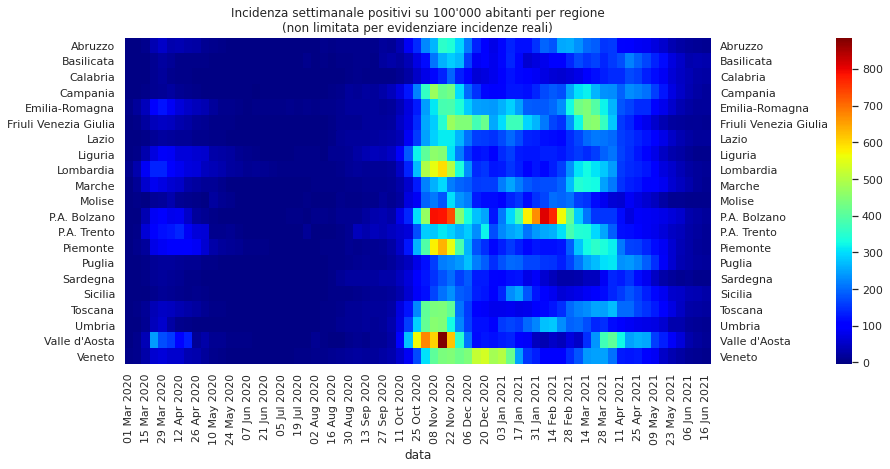

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(
    fp_w.T,
    #vmax=500,
    #cmap='gray_r', 
    cmap='jet', 
    #linewidths=.01, linecolor='k',
    cbar_kws=dict(pad=.15),
    ax=ax
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True, rotation=0)
#x_latest = ax.get_xticks()[-2:].mean()
#ax.axvline(x_latest, color='k', lw=3)
ax.set(
    title="Incidenza settimanale positivi su 100'000 abitanti per regione\n"
    "(non limitata per evidenziare incidenze reali)",
    ylabel=None
)
plt.show()

In [20]:
fp1 = it.pivot_table(index='data', columns='denominazione_regione', values='deceduti') 

fp1_w = fp1.diff().resample('W').sum()

for regione in fp1_w.columns:
    fp1_w.loc[:,regione] = fp1_w.loc[:,regione] / (pop_reg[pop_reg.Territorio==regione].Value.values) * 100000

fp1_w.index = fp1_w.index.strftime('%d %b %Y')
#fp1_w = fp1_w.diff()
fp1_w[fp1_w<0] = 0

In [21]:
fp1_latest = pd.DataFrame(fp1.diff().iloc[-7:].sum()).T

In [22]:
for regione in fp1_latest.columns:
    fp1_latest.loc[:,regione] = fp1_latest.loc[:,regione] / (pop_reg[pop_reg.Territorio==regione].Value.values) * 100000

fp1_latest.index = [fp1.index.max().strftime('%d %b %Y')]

fp1_latest.index.name = 'data'

fp1_w = fp1_w.iloc[:-1].append(fp1_latest)

# Nuovi decessi

In [23]:
dfId = dfX[[
    'regione',
    'incidenza_deceduti_ultima_settimana', 'incidenza_deceduti_ultimi_7_giorni'
]].set_index('regione')
dfId.columns = ['ultima settimana', 'ultimi 7 giorni']
dfId['differenza'] = dfId['ultimi 7 giorni'] - dfId['ultima settimana']
dfId.style.set_caption("INCIDENZA DECEDUTI (ordine alfabetico)").format(
    {
        'ultima settimana': '{:.2f}',
        'ultimi 7 giorni': '{:.2f}',
        'differenza': '{:+.2f}'
    }
)

,ultima settimana,ultimi 7 giorni,differenza
regione,,,
Abruzzo,0.84,0.61,-0.23
Basilicata,0.18,0.36,+0.18
Calabria,1.14,0.94,-0.21
Campania,1.64,1.30,-0.35
Emilia-Romagna,0.54,0.40,-0.13
Friuli Venezia Giulia,0.17,0.17,+0.00
Lazio,0.75,0.95,+0.20
Liguria,0.71,0.19,-0.52
Lombardia,0.56,0.46,-0.11


In [24]:
dfId.sort_values(by='ultima settimana', ascending=False).style.set_caption(
    "INCIDENZA DECEDUTI (ordine ultima settimana)"
).format(
    {
        'ultima settimana': '{:.2f}',
        'ultimi 7 giorni': '{:.2f}',
        'differenza': '{:+.2f}'
    }
)

,ultima settimana,ultimi 7 giorni,differenza
regione,,,
Campania,1.64,1.30,-0.35
Umbria,1.59,1.36,-0.23
Toscana,1.56,1.29,-0.27
Puglia,1.17,0.62,-0.55
Calabria,1.14,0.94,-0.21
Abruzzo,0.84,0.61,-0.23
Lazio,0.75,0.95,+0.20
Liguria,0.71,0.19,-0.52
Sardegna,0.67,0.25,-0.43


In [25]:
dfId.sort_values(by='differenza', ascending=False).style.set_caption(
    "INCIDENZA DECEDUTI (ordine differenza)"
).format(
    {
        'ultima settimana': '{:.2f}',
        'ultimi 7 giorni': '{:.2f}',
        'differenza': '{:+.2f}'
    }
)

,ultima settimana,ultimi 7 giorni,differenza
regione,,,
Lazio,0.75,0.95,+0.20
Basilicata,0.18,0.36,+0.18
Sicilia,0.64,0.76,+0.12
Molise,0.00,0.00,+0.00
P.A. Trento,0.18,0.18,+0.00
Valle d'Aosta,0.00,0.00,+0.00
Friuli Venezia Giulia,0.17,0.17,+0.00
Piemonte,0.48,0.41,-0.07
Lombardia,0.56,0.46,-0.11


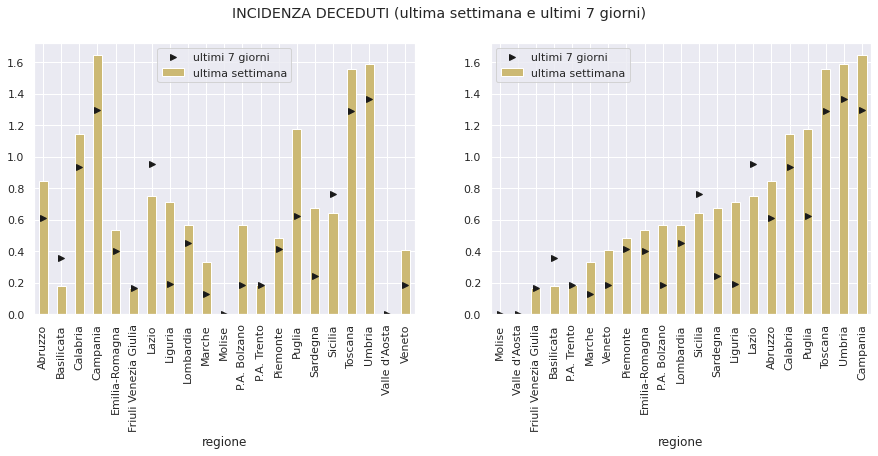

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
dfId.plot(y='ultimi 7 giorni', ax=ax[0], color='k', marker='>', ls='none')
dfId.plot(y='ultima settimana', ax=ax[0], color='y', kind='bar')

dfId.sort_values(by='ultima settimana').plot(y='ultimi 7 giorni', ax=ax[1], color='k', marker='>', ls='none')
dfId.sort_values(by='ultima settimana').plot(y='ultima settimana', ax=ax[1], kind='bar', color='y')

fig.suptitle('INCIDENZA DECEDUTI (ultima settimana e ultimi 7 giorni)')
plt.show()

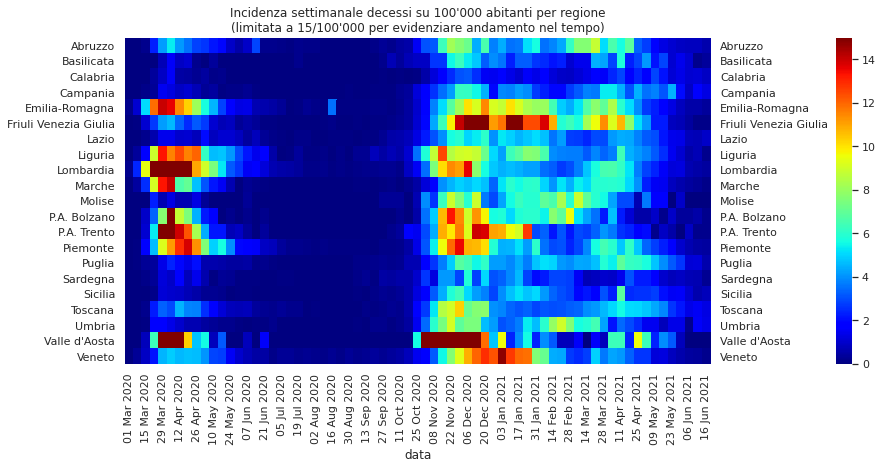

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(
    fp1_w.T,
    vmax=15,
    cmap='jet', 
    #linewidths=.01, linecolor='k',
    cbar_kws=dict(pad=.15),
    ax=ax
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True, rotation=0)
#x_latest = ax.get_xticks()[-2:].mean()
#ax.axvline(x_latest, color='k', lw=3)
ax.set(
    title="Incidenza settimanale decessi su 100'000 abitanti per regione\n"
    "(limitata a 15/100'000 per evidenziare andamento nel tempo)",
    ylabel=None
)
plt.show()

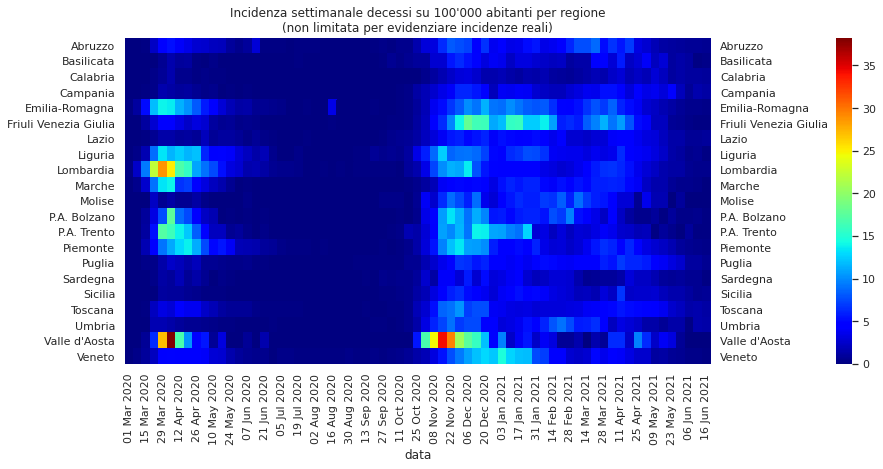

In [28]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(
    fp1_w.T,
    #vmax=30,
    cmap='jet', 
    #linewidths=.01, linecolor='k',
    cbar_kws=dict(pad=.15),
    ax=ax
)
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True, rotation=0)
#x_latest = ax.get_xticks()[-2:].mean()
#ax.axvline(x_latest, color='k', lw=3)
ax.set(
    title="Incidenza settimanale decessi su 100'000 abitanti per regione\n"
    "(non limitata per evidenziare incidenze reali)",
    ylabel=None
)
plt.show()

# Incidenza Positivi

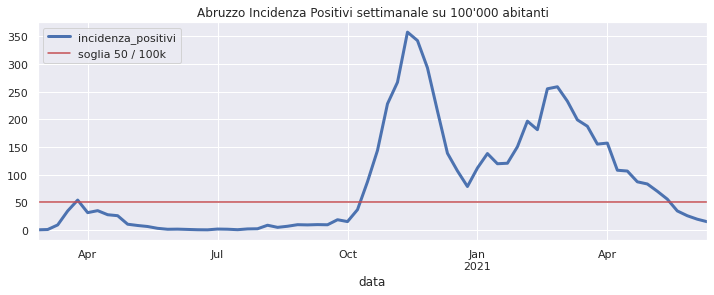

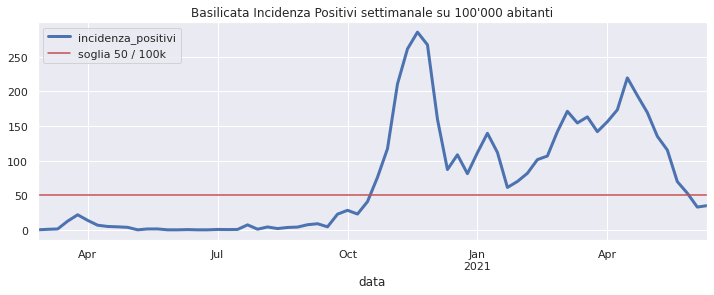

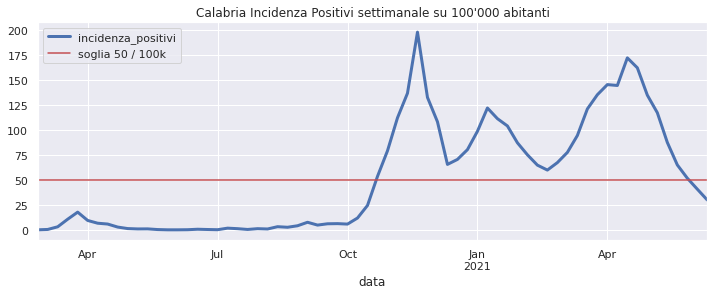

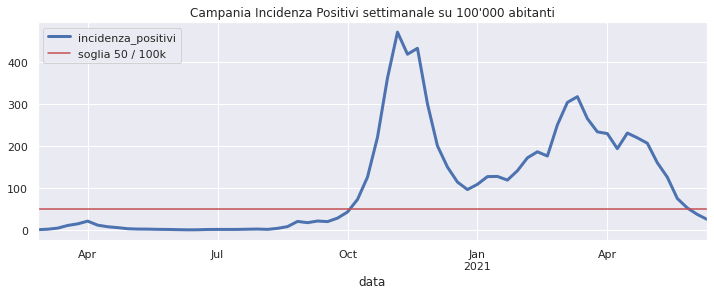

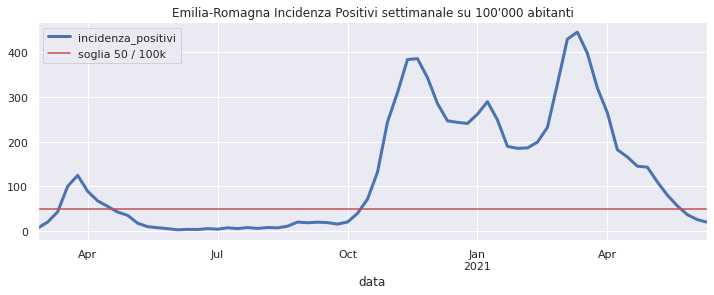

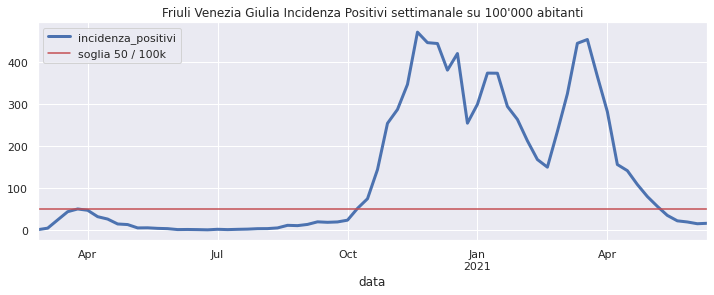

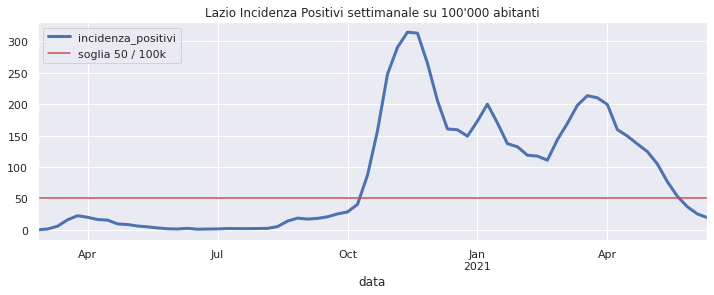

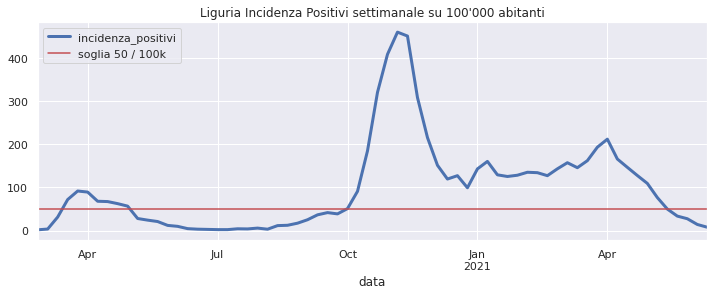

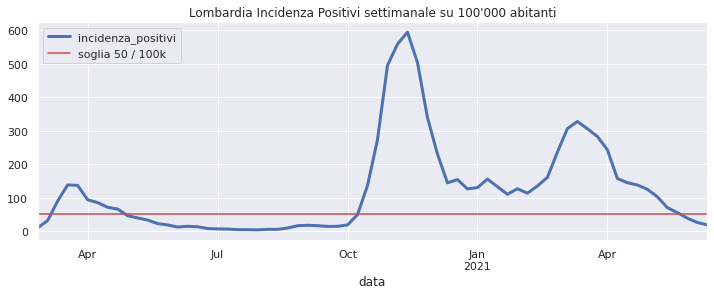

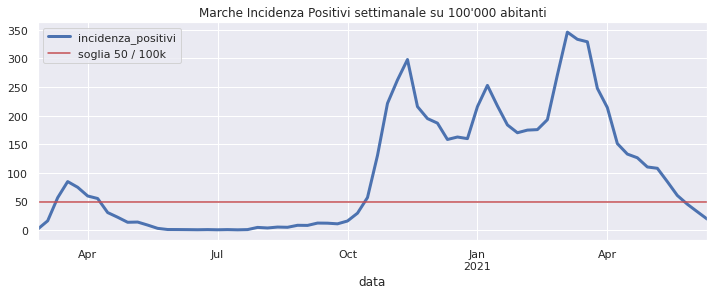

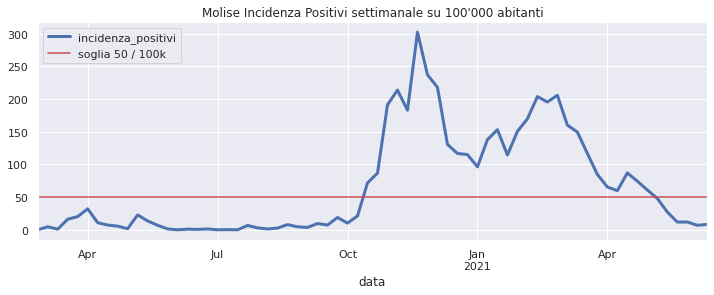

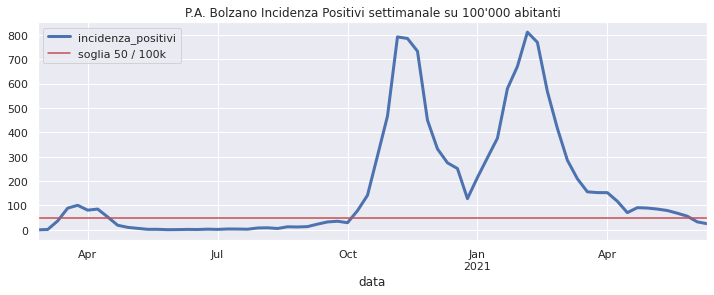

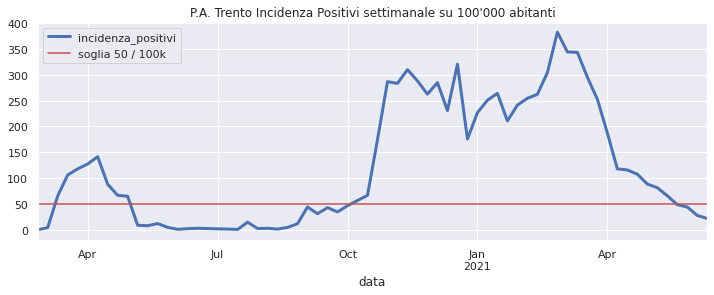

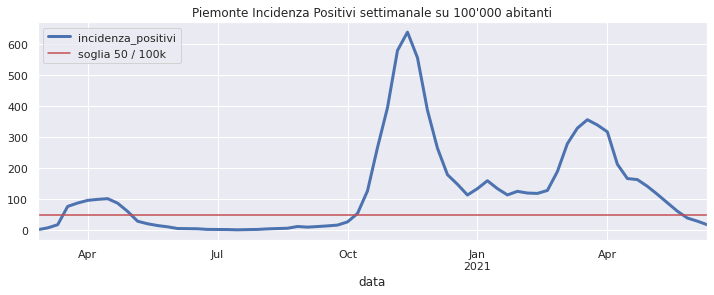

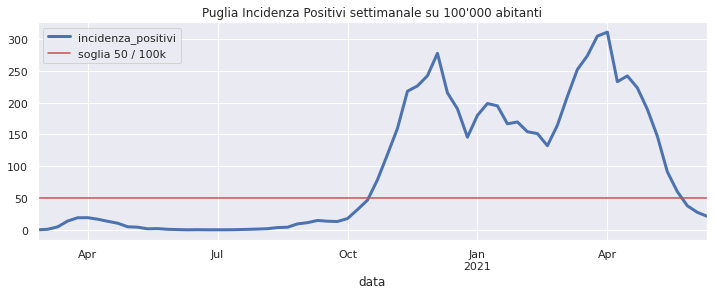

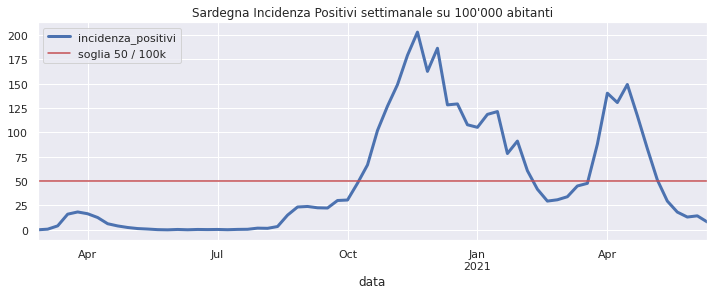

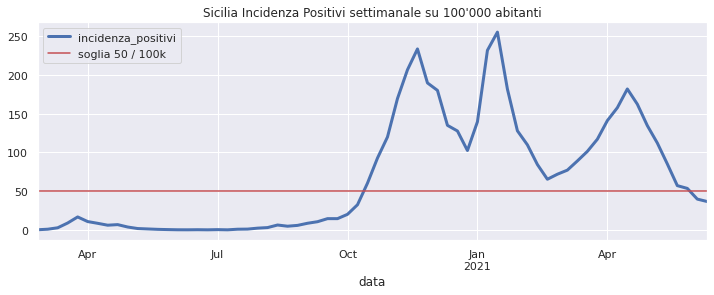

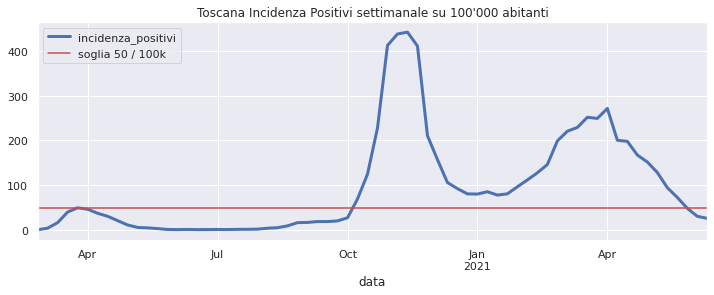

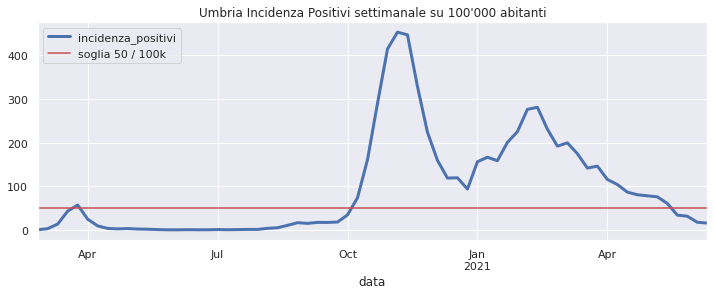

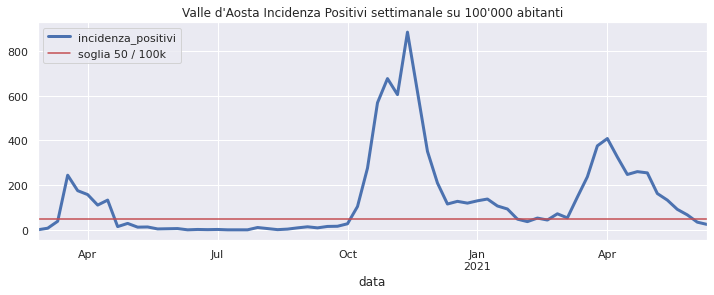

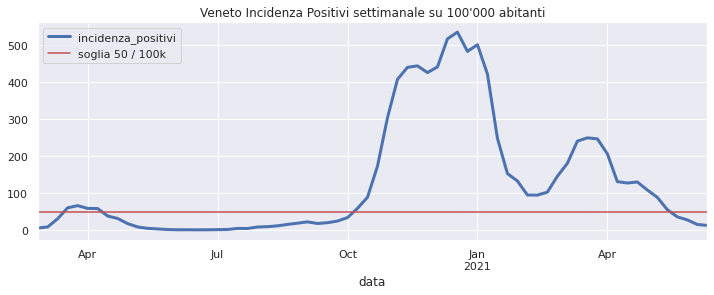

# Incidenza Deceduti

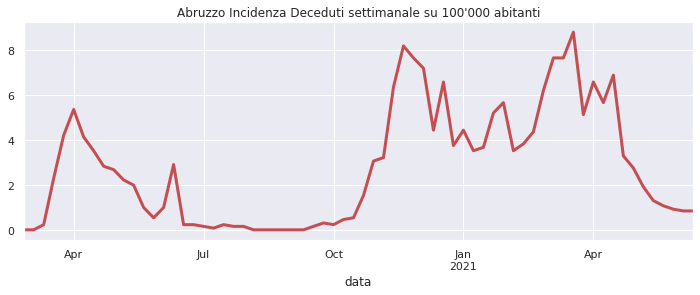

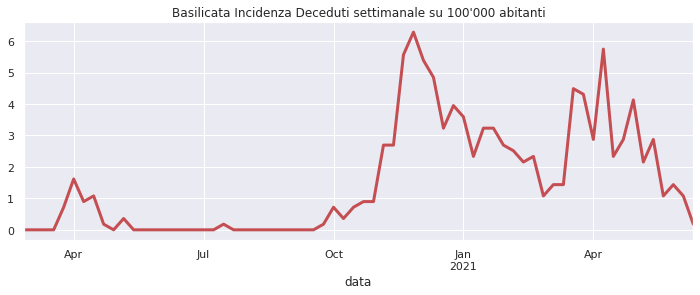

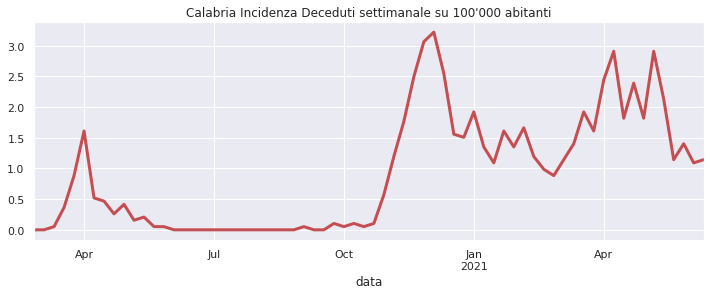

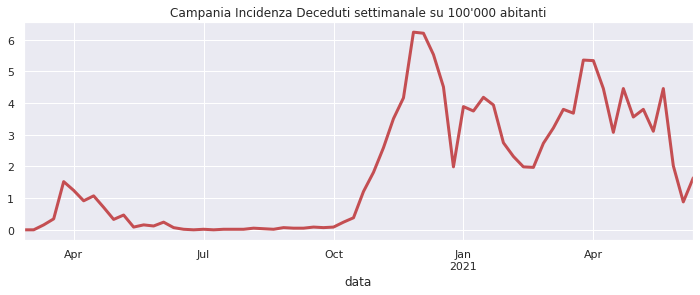

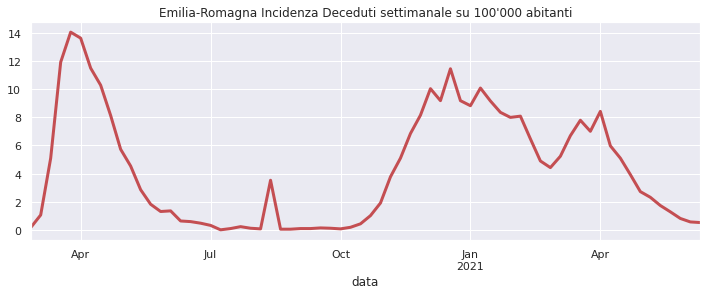

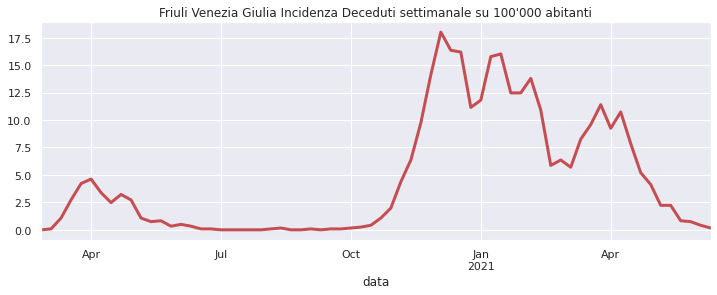

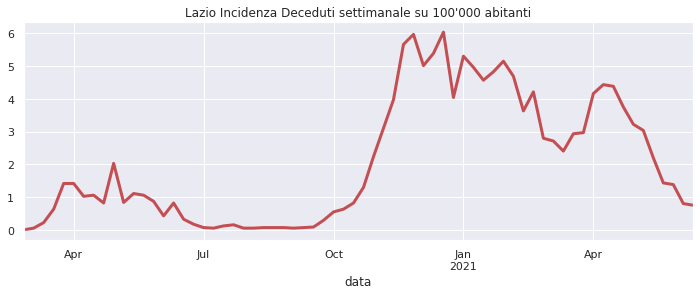

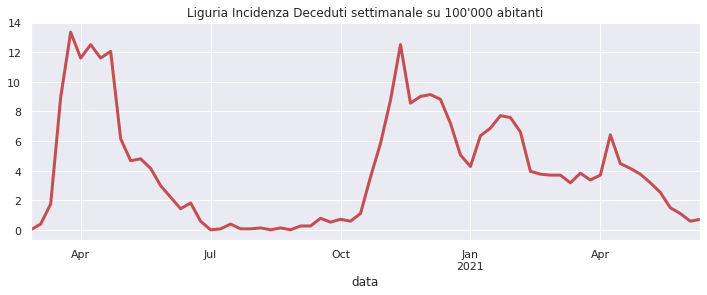

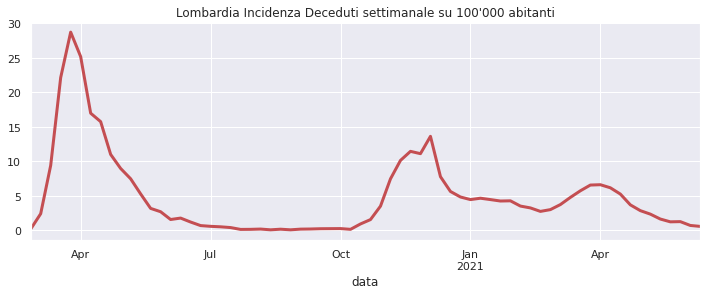

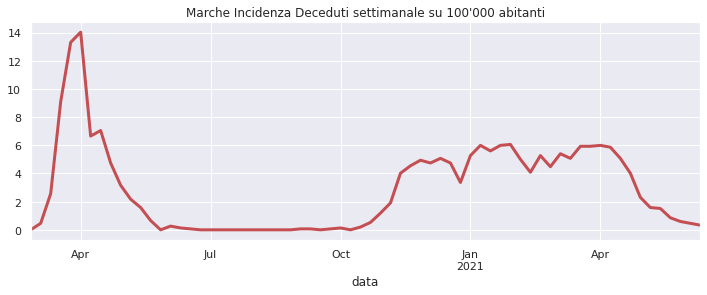

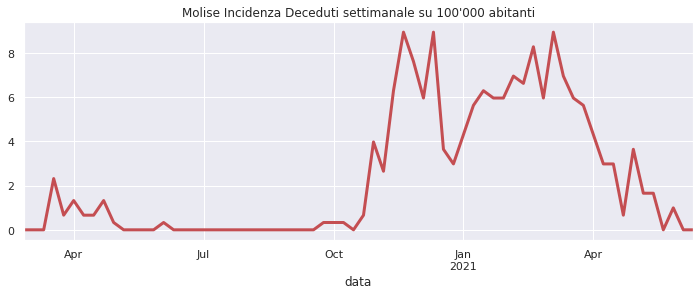

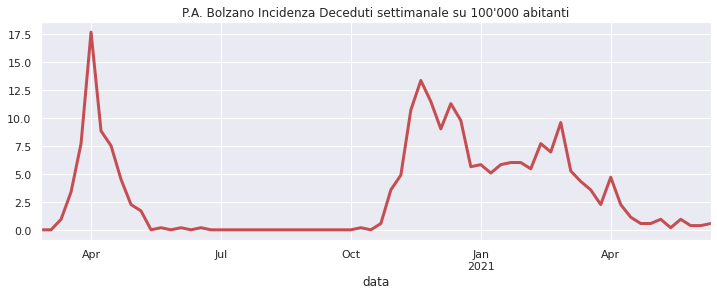

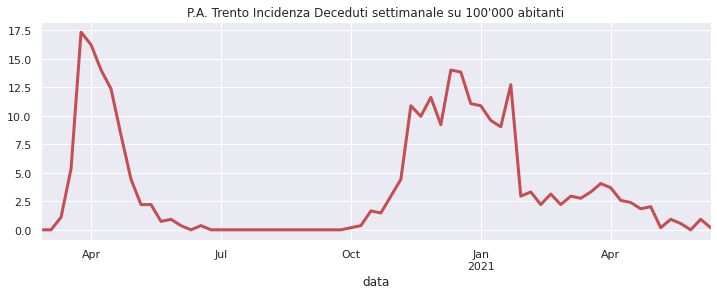

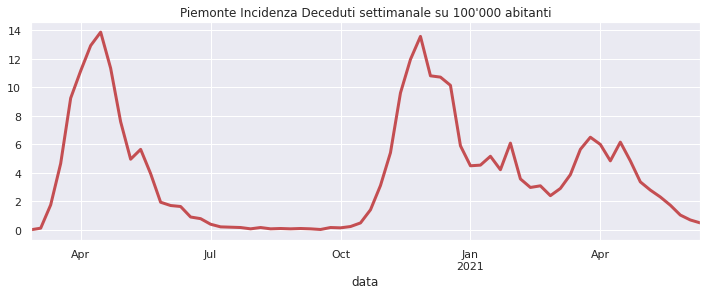

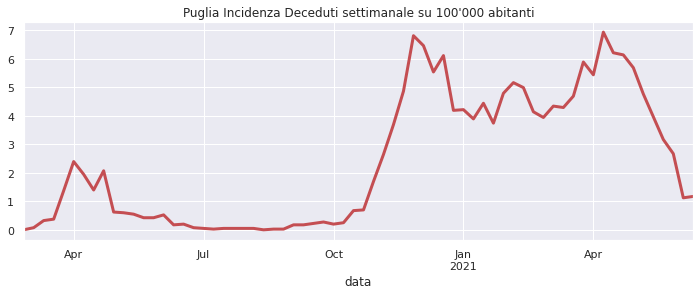

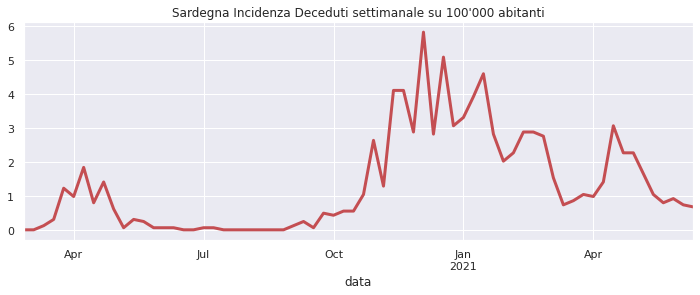

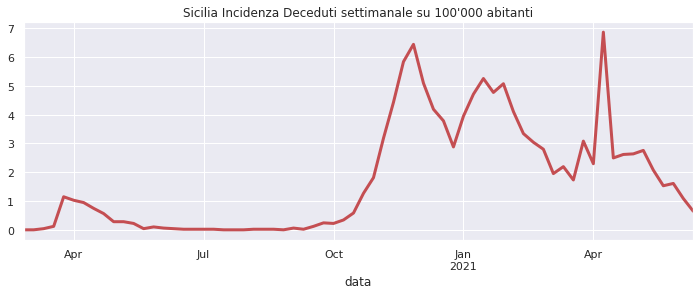

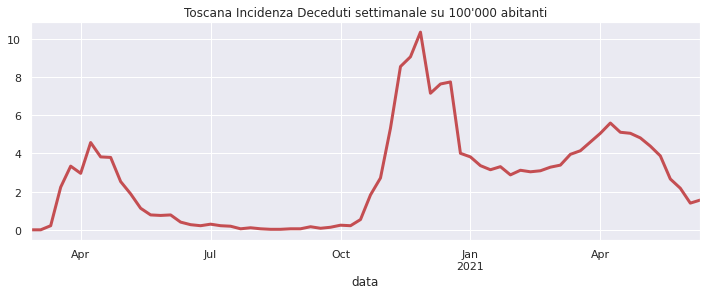

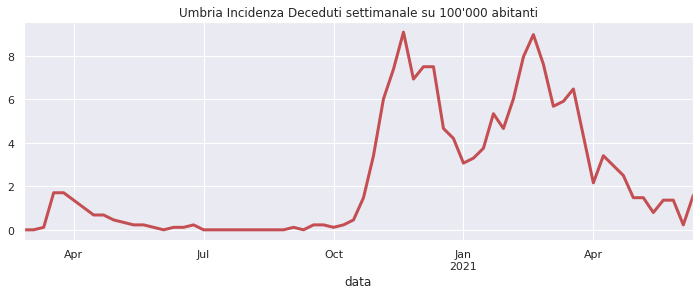

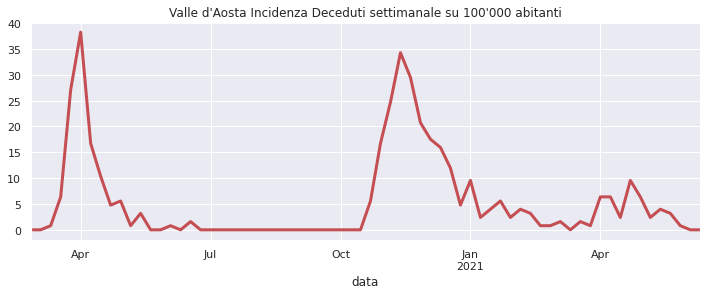

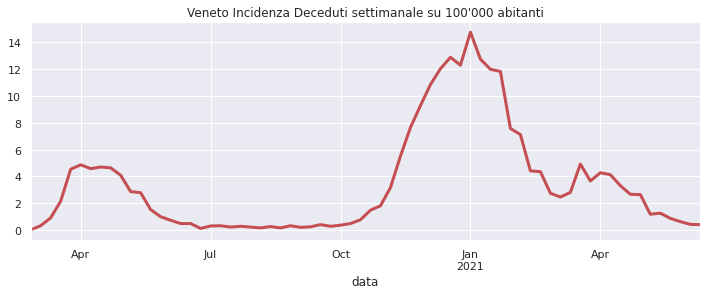

# Incidenza Guariti

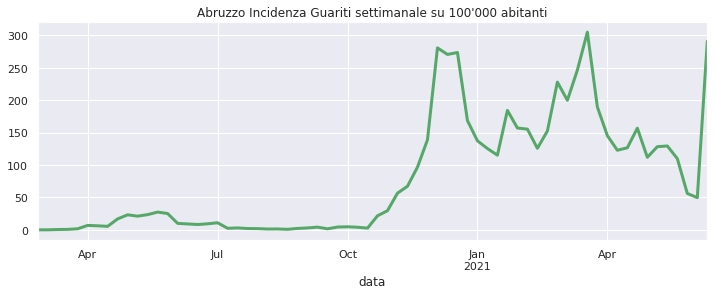

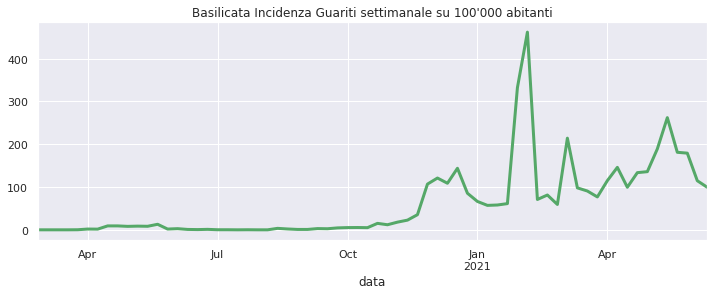

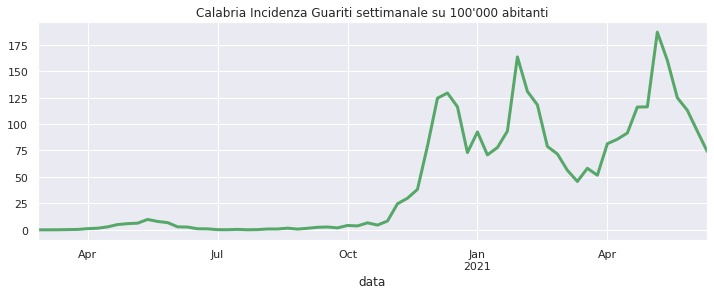

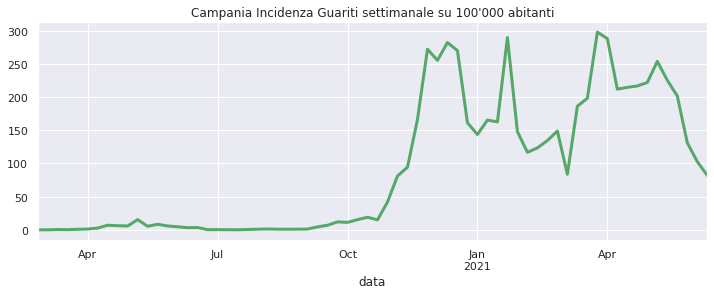

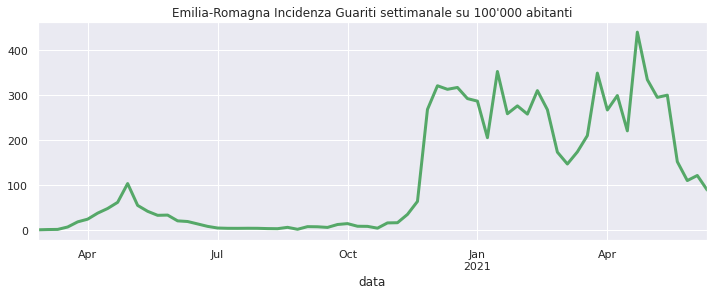

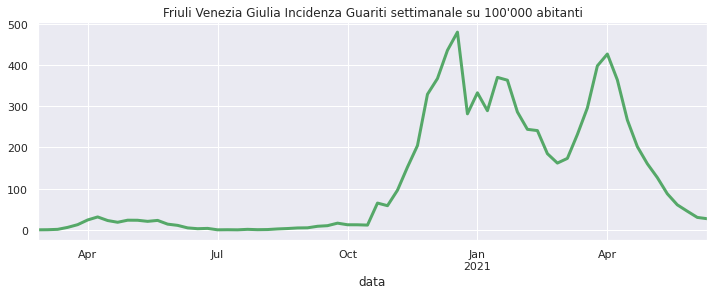

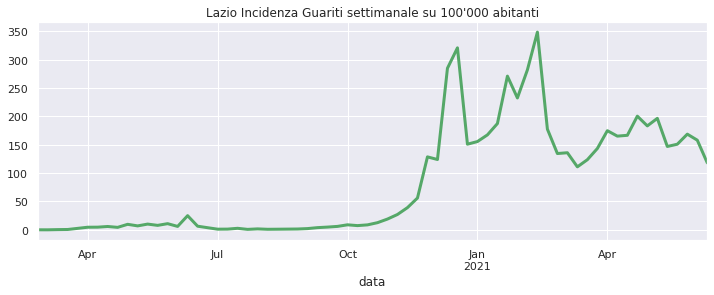

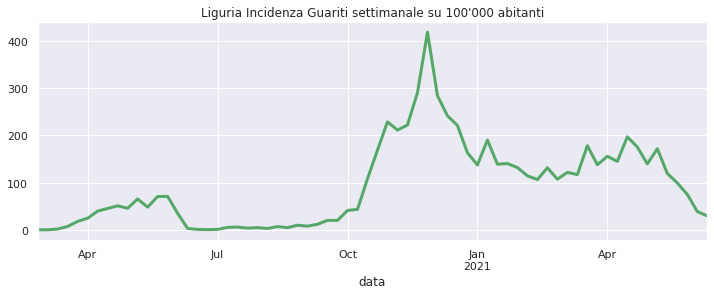

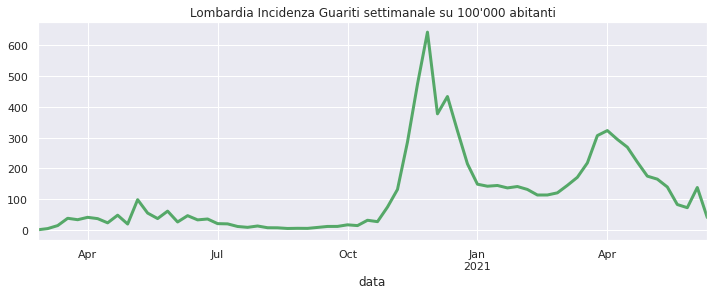

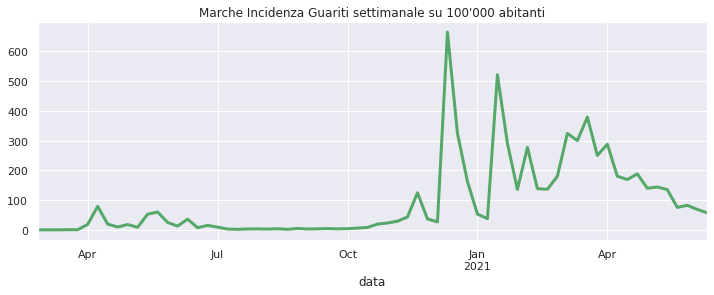

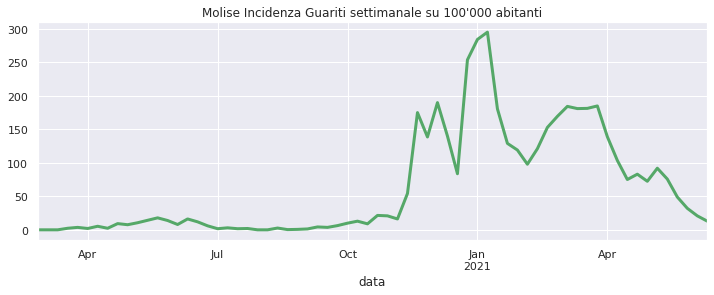

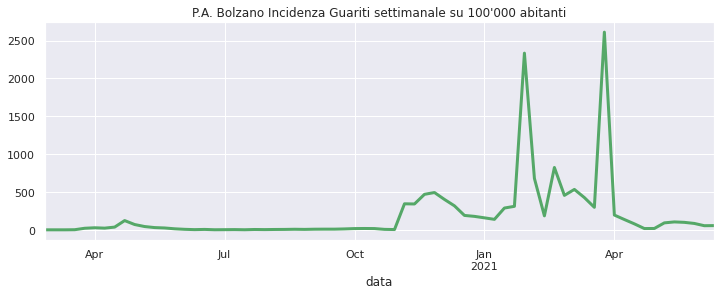

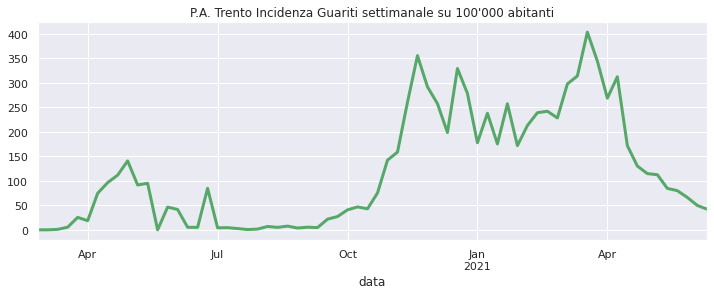

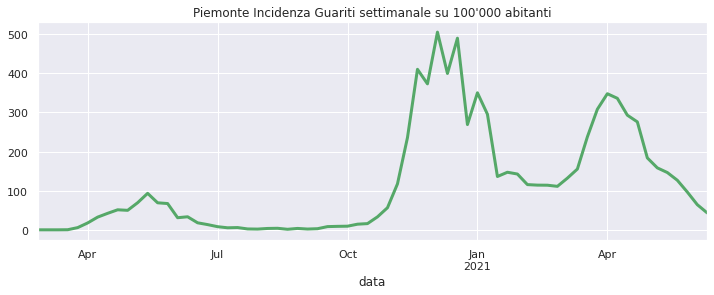

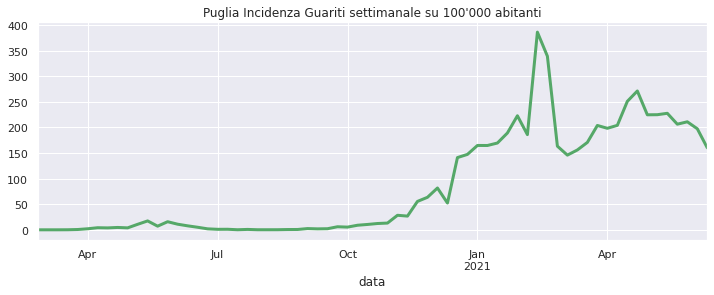

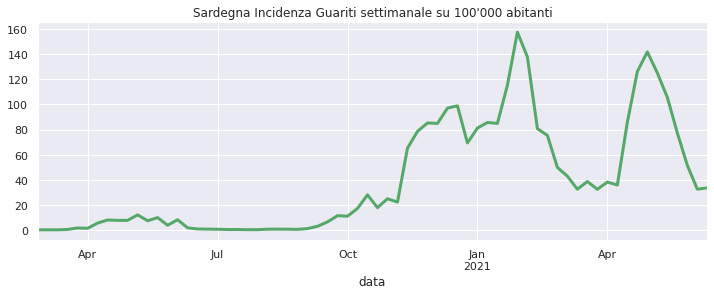

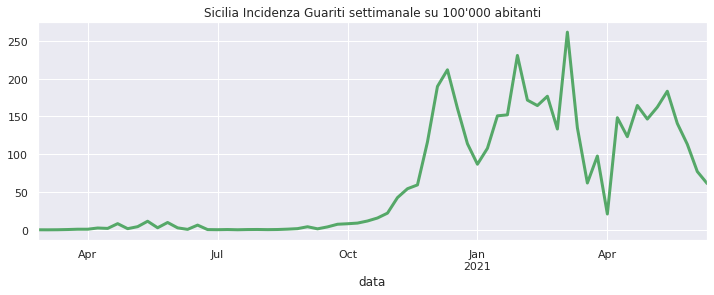

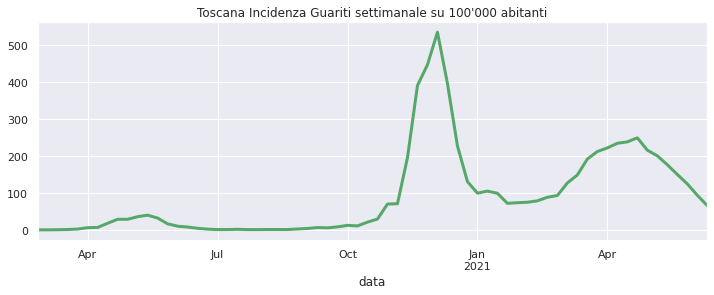

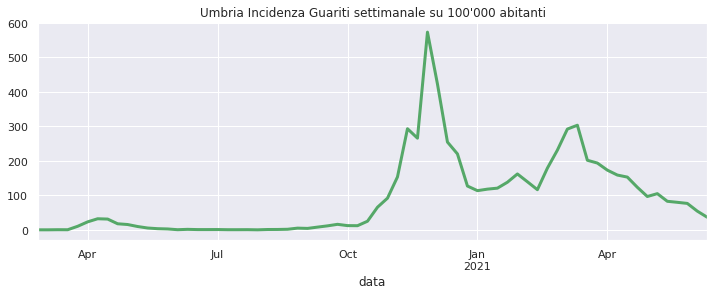

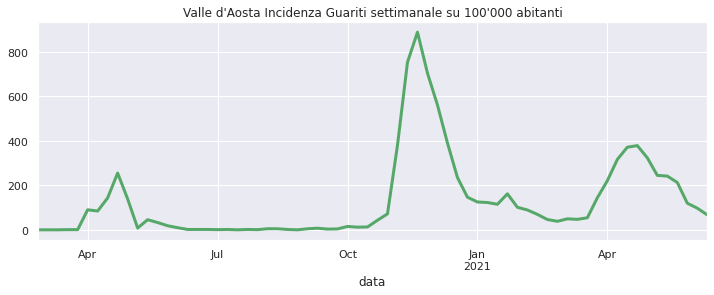

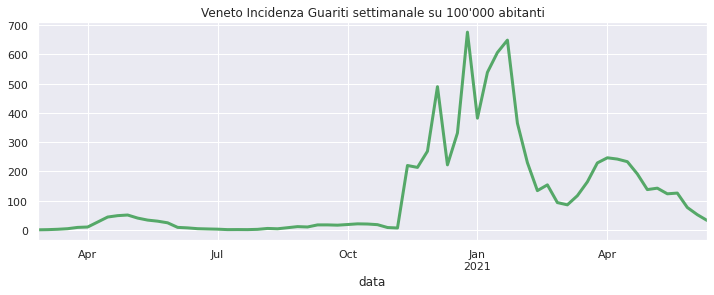

In [29]:
colors = ['b', 'r', 'g']

for i, y in enumerate(['incidenza_positivi', 'incidenza_deceduti', 'incidenza_guariti']):
    title = y.replace('_', ' ').title()
    display(Markdown(f"# {title}"))
    for regione in dfW.regione.unique():
        regW = dfW[dfW.regione==regione][:-1]
        regW.loc[regW[y]<0, y] = 0
        ax = regW.plot(
            y=y,
            lw=3, color=colors[i],
            title=f"{regione} {title} settimanale su 100'000 abitanti",
            legend=False,
            figsize=(12, 4)
        )
        if y == 'incidenza_positivi':
            ax.axhline(50, color='r', label='soglia 50 / 100k')
            ax.legend(loc='upper left')
        plt.show()